# Model Test #4
* Cleaned/imputed negative values
* Balanced classes

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-05-31 10:26:15.141065


In [2]:
est = pd.read_csv('s3://bleeding-hearts/workingdata/merge_est.csv')
pct = pd.read_csv('s3://bleeding-hearts/workingdata/merge_pct.csv')
est.info()
pct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(1), int64(143), object(4)
memory usage: 20.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(102), int64(42), object(4)
memory usage: 20.6+ MB


In [3]:
for i in [est,pct]:
    i.drop(columns=['Unnamed: 0'],inplace=True)
    cols=list(i)
    all_miss = []
    for c in cols:
        if i[c].dtypes != object:
            i.loc[i[c] < 0, c] = np.nan
        if len(i) - i[c].count() == len(i):
            all_miss.append(c)
    i.drop(columns=all_miss,inplace=True)
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 127 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(123), object(4)
memory usage: 17.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 131 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(127), object(4)
memory usage: 18.2+ MB


In [4]:
def assess_missing(df):
    missing_dict = {}
    cols=list(df)
    for c in cols:
        if len(df) - df[c].count() > 0:
             missing_dict[c] = ((len(df) - df[c].count())/len(df))*100
    return missing_dict

In [5]:
est_missing = assess_missing(est)
est_missing

{'COMMUTING TO WORK_Mean travel time to work (minutes)': 0.35149384885764495,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_Total households_Median household income (dollars)': 0.19771528998242532,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_Total households_Mean household income (dollars)': 0.21968365553602814,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings_Mean earnings (dollars)': 0.2251757469244288,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With Social Security_Mean Social Security income (dollars)': 0.5437170474516696,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With retirement income_Mean retirement income (dollars)': 0.8018453427065025,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With Supplemental Security Income_Mean Supplemental Security Income (dollars)': 10.209797891036906,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With cash public assistance income_Mean cash

In [6]:
pct_missing = assess_missing(pct)
pct_missing

{'EMPLOYMENT STATUS_Population 16 years and over_In labor force': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces': 0.027460456942003518,
 'EMPLOYMENT STATUS_Population 16 years and over_Not in labor force': 0.027460456942003518,
 'EMPLOYMENT STATUS_Civilian labor force_Unemployment Rate': 0.04942882249560633,
 'EMPLOYMENT STATUS_Females 16 years and over_In labor force': 0.04393673110720562,
 'EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force': 0.04393673110720562,
 'EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force_Employed': 0.043936

In [7]:
#column names are the same in est and pct
cols=list(est)
cat_cols=cols[-8:-5]
num_cols=cols[-4:]
print(cat_cols,'\n\n',num_cols)

['Child Opportunity Levels, education domain, nationally- normed', 'Child Opportunity Levels, health and environment domain, nationally-normed', 'Child Opportunity Levels, social and economic domain, nationally-normed'] 

 ['Child Opportunity Scores, education domain, nationally- normed', 'Child Opportunity Scores, health and environment domain, nationally-normed', 'Child Opportunity Scores, social and economic domain, nationally-normed', 'Child Opportunity Scores, overall COI, nationally-normed']


In [8]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

In [9]:
def viz_cb(y,lst):
    visualizer = ClassBalance(labels=lst)
    visualizer.fit(y)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

In [10]:
def class_balance(df,target):
    print('Raw Value Counts:','\n',df[target].value_counts())
    X = df.loc[:, df.columns != target]
    y = df[target]
    #make a dataframe of value counts and a list of the values in the target
    df1 = y.value_counts().to_frame('count').reset_index(level=0).rename(columns={'index':'value'})
    label_lst = list(df1['value'])
    
    viz_cb(y,label_lst)

    #identify minimum value number and label name
    mi = df1['count'].min()
    name = df1.loc[df1['count'] == mi,'value'].iloc[0]
    print('min value is',name,'in values',label_lst)

    seed = 123
    # Downsample majority class
    
    #use min value number and label name to resample the dataframe
    df2 = pd.concat([resample(df[df[target]== i],
                            replace=False,
                            n_samples=mi,
                            random_state=seed) for i in label_lst if i != name]).append(df[df[target]== name])
    print('Resampled Value Counts:','\n',df2[target].value_counts())
    X = df2.loc[:, df.columns != target]
    y = df2[target]
    viz_cb(y,label_lst)
    return df2

In [11]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

In [12]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [13]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Very Low','Low','Moderate','High','Very High'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

Target = Child Opportunity Levels, education domain, nationally- normed
Raw Value Counts: 
 Low          5258
Moderate     4622
High         3095
Very Low     3034
Very High    2199
Name: Child Opportunity Levels, education domain, nationally- normed, dtype: int64


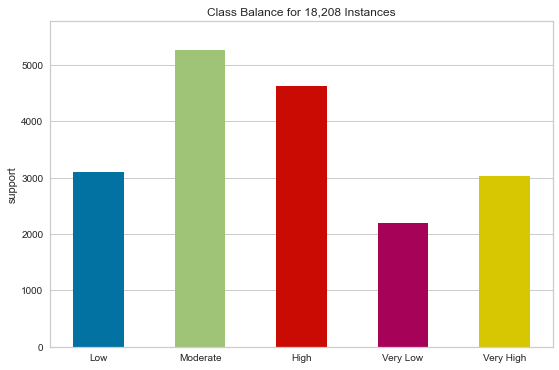

min value is Very High in values ['Low', 'Moderate', 'High', 'Very Low', 'Very High']
Resampled Value Counts: 
 Moderate     2199
Low          2199
Very High    2199
Very Low     2199
High         2199
Name: Child Opportunity Levels, education domain, nationally- normed, dtype: int64


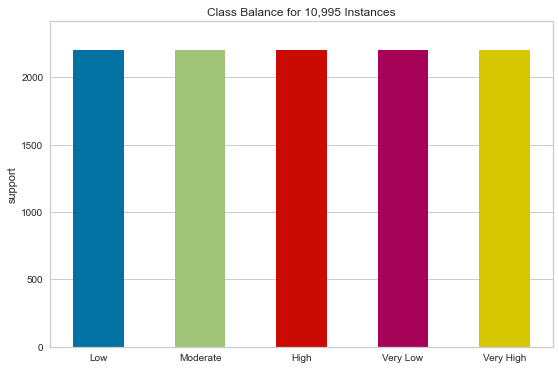

(8796, 126) (8796,)
(2199, 126) (2199,)
F1 SCORE SVC: 0.8043656207366985


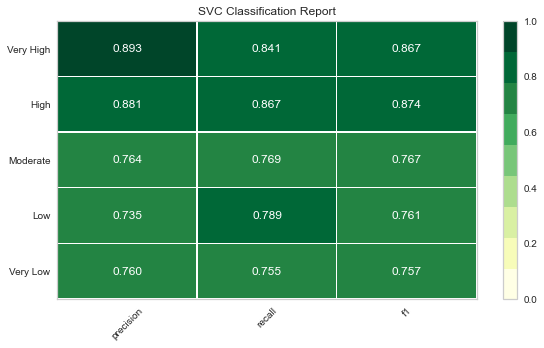

F1 SCORE NuSVC: 0.8119145065939064


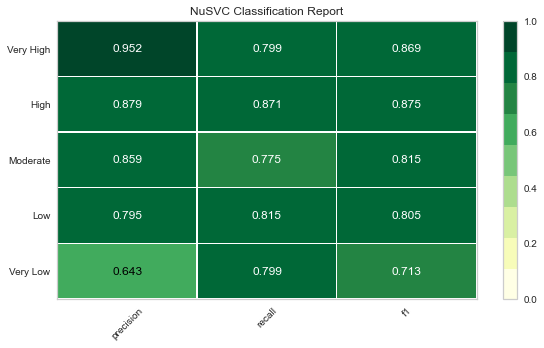

F1 SCORE LinearSVC: 0.8303774442928604


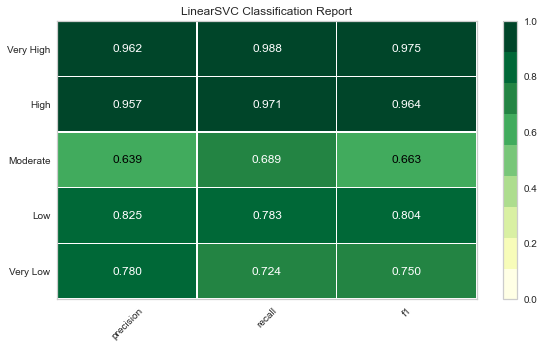

F1 SCORE SGDClassifier: 0.6106412005457026


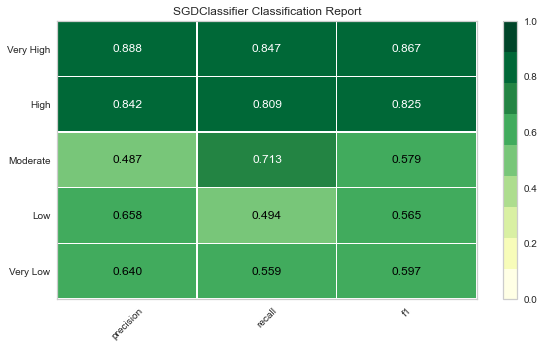

F1 SCORE KNeighborsClassifier: 0.6673942701227831


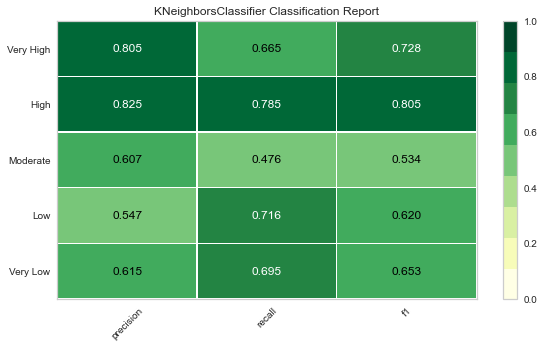

F1 SCORE LogisticRegression: 0.6202819463392452


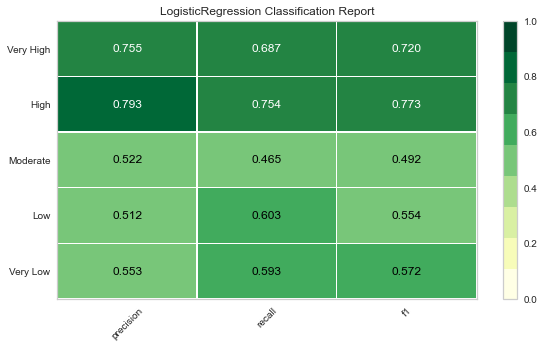

F1 SCORE LogisticRegressionCV: 0.8767621646202819


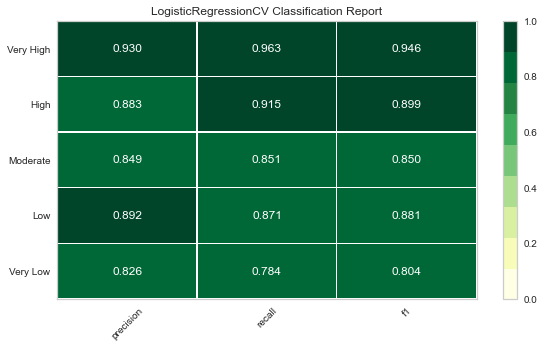

F1 SCORE BaggingClassifier: 1.0


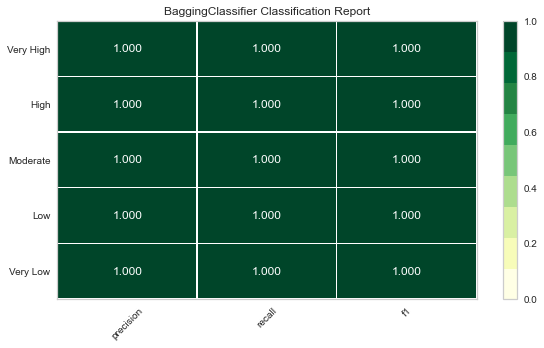

F1 SCORE ExtraTreesClassifier: 1.0


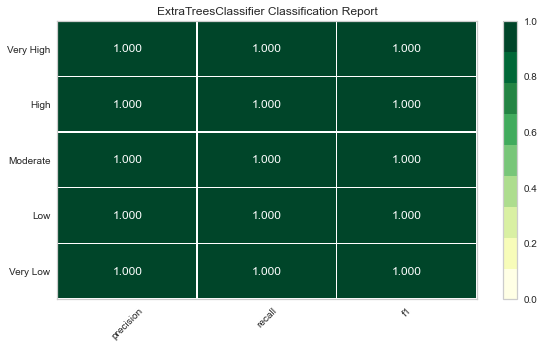

F1 SCORE RandomForestClassifier: 1.0


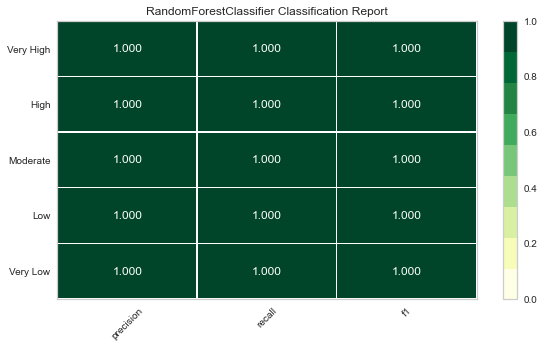

Target = Child Opportunity Levels, health and environment domain, nationally-normed
Raw Value Counts: 
 Very Low     6438
Low          4092
Moderate     3337
High         2708
Very High    1633
Name: Child Opportunity Levels, health and environment domain, nationally-normed, dtype: int64


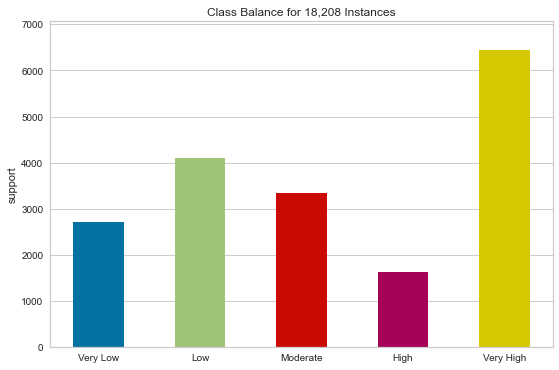

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 Moderate     1633
Low          1633
Very High    1633
Very Low     1633
High         1633
Name: Child Opportunity Levels, health and environment domain, nationally-normed, dtype: int64


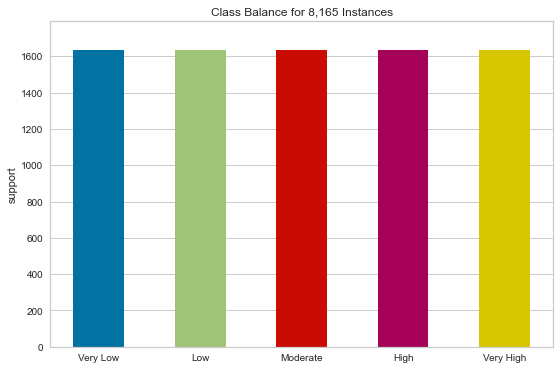

(6532, 126) (6532,)
(1633, 126) (1633,)
F1 SCORE SVC: 0.8222902633190448


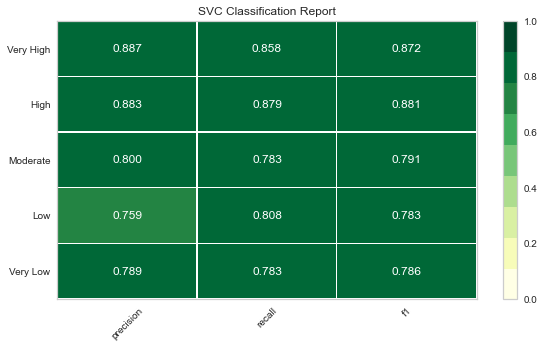

F1 SCORE NuSVC: 0.8954072259644825


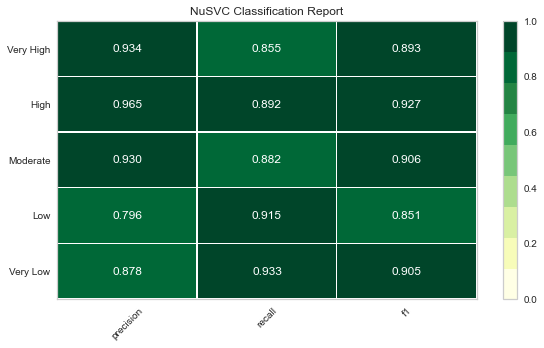

F1 SCORE LinearSVC: 0.8056338028169014


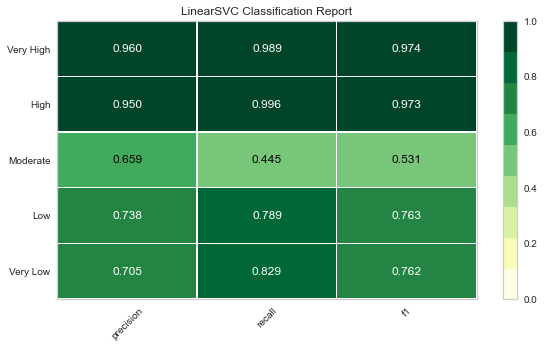

F1 SCORE SGDClassifier: 0.5909369259032455


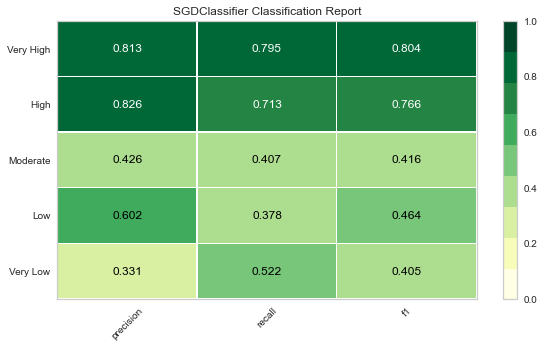

F1 SCORE KNeighborsClassifier: 0.6319657072872015


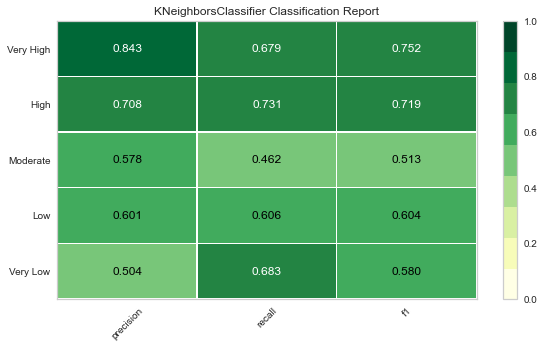

F1 SCORE LogisticRegression: 0.5522351500306185


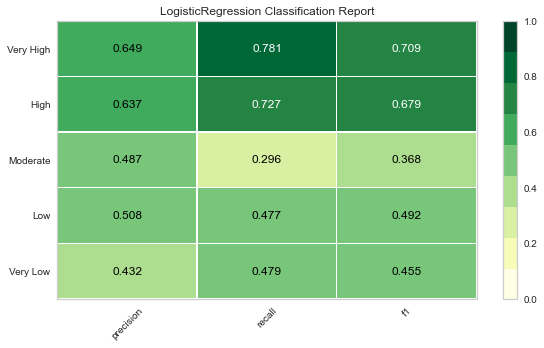

F1 SCORE LogisticRegressionCV: 0.8461726883037355


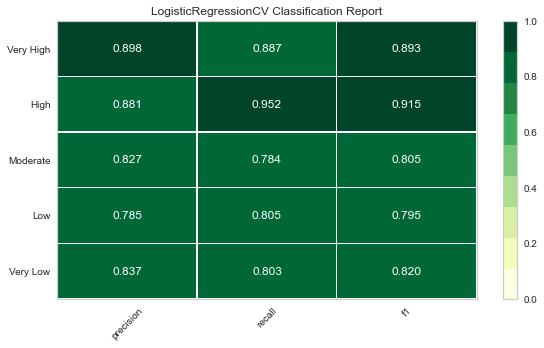

F1 SCORE BaggingClassifier: 1.0


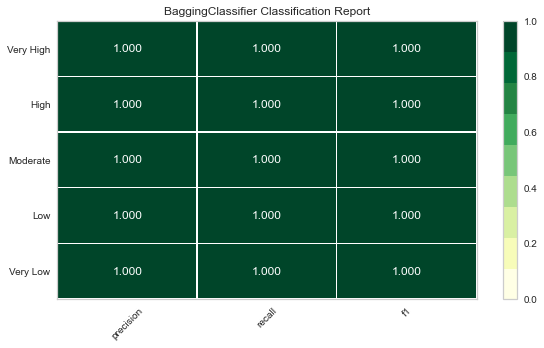

F1 SCORE ExtraTreesClassifier: 1.0


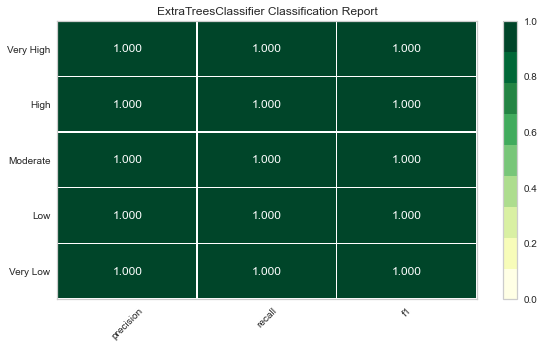

F1 SCORE RandomForestClassifier: 1.0


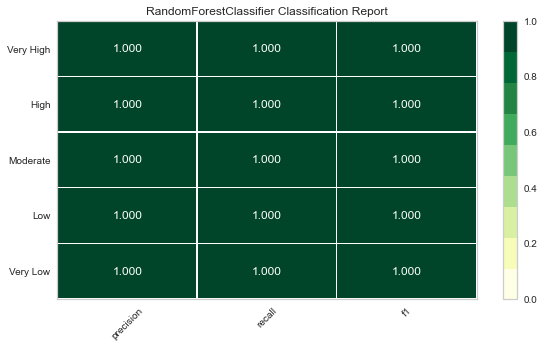

Target = Child Opportunity Levels, social and economic domain, nationally-normed
Raw Value Counts: 
 Very Low     4170
Low          3927
Moderate     3814
High         3356
Very High    2941
Name: Child Opportunity Levels, social and economic domain, nationally-normed, dtype: int64


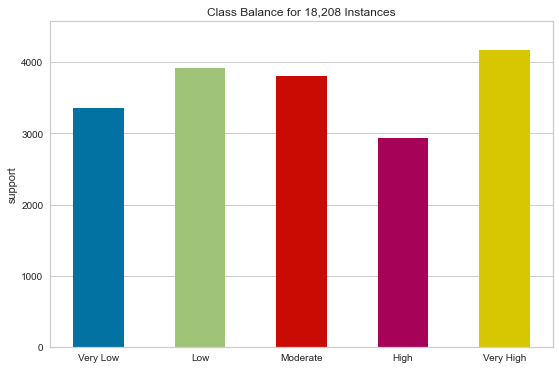

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 Moderate     2941
Low          2941
Very High    2941
Very Low     2941
High         2941
Name: Child Opportunity Levels, social and economic domain, nationally-normed, dtype: int64


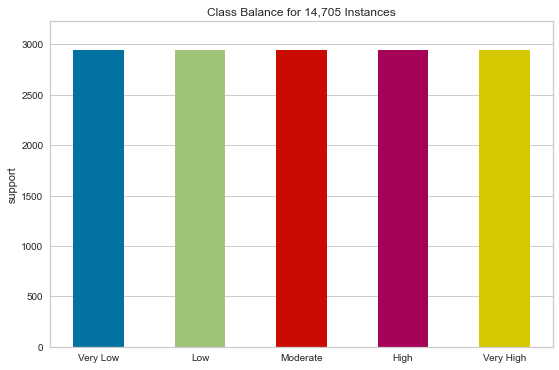

(11764, 126) (11764,)
(2941, 126) (2941,)
F1 SCORE SVC: 0.8297177830669841


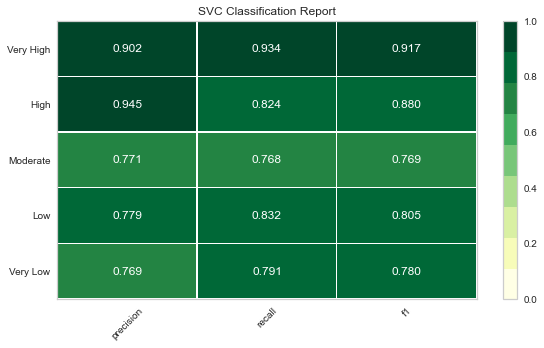

F1 SCORE NuSVC: 0.7605576334580075


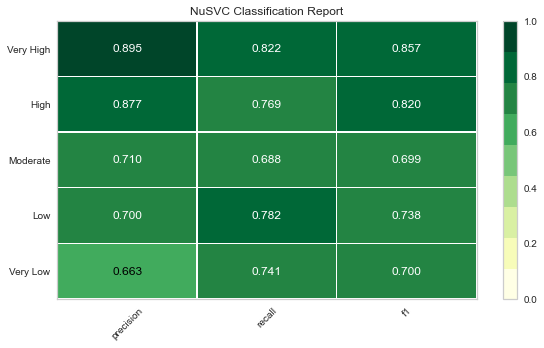

F1 SCORE LinearSVC: 0.8318259095545733


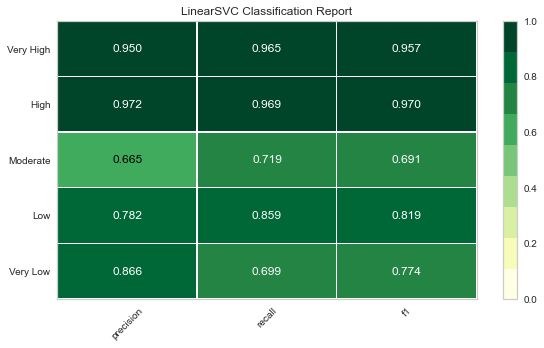

F1 SCORE SGDClassifier: 0.7241754505270315


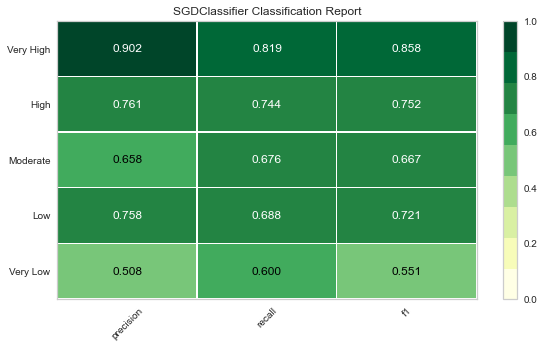

F1 SCORE KNeighborsClassifier: 0.7424005440326421


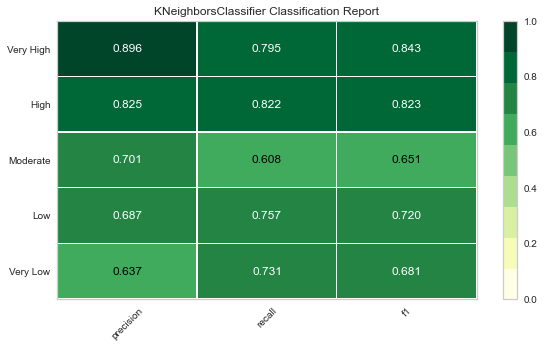

F1 SCORE LogisticRegression: 0.7680380822849371


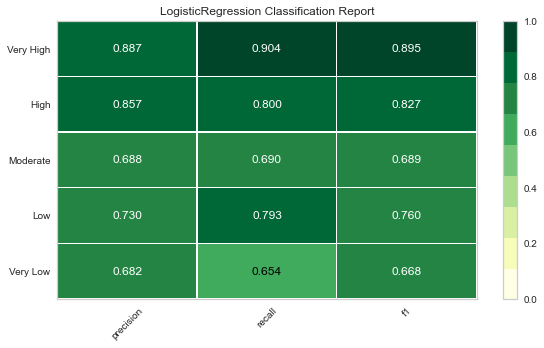

F1 SCORE LogisticRegressionCV: 0.8531791907514451


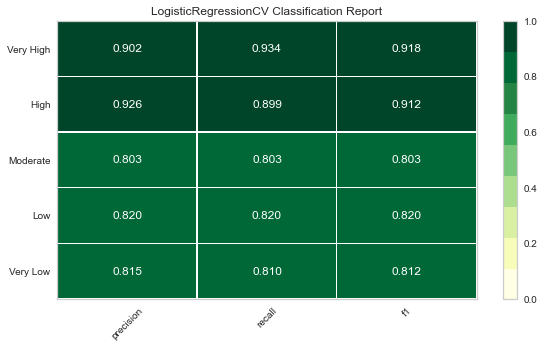

F1 SCORE BaggingClassifier: 1.0


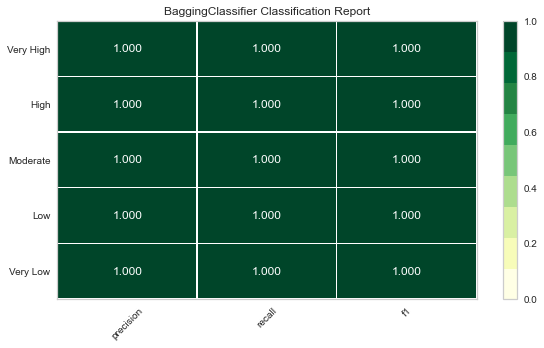

F1 SCORE ExtraTreesClassifier: 1.0


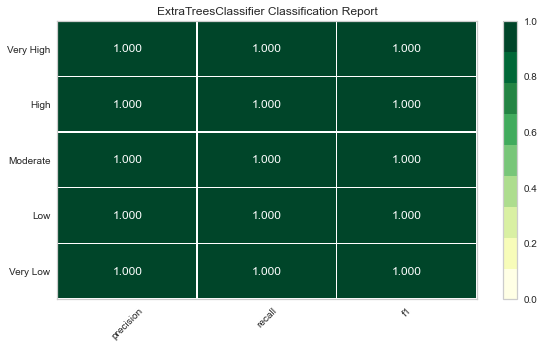

F1 SCORE RandomForestClassifier: 1.0


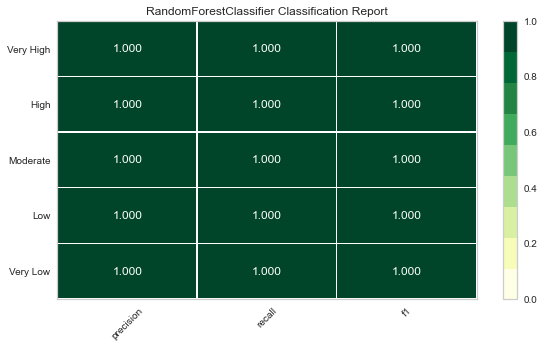

In [14]:
for i in cat_cols:
    print('Target =', i)
    data = class_balance(est,i)
    X = data.loc[:, data.columns != i]
    y = data[i]
    train_test(X,y)
    for model in models:
        try:
            score_model(X, y, model)
            visualize_model(X, y, model)
        except:
            print("error in",model)

Target = Child Opportunity Levels, education domain, nationally- normed
Raw Value Counts: 
 Low          5258
Moderate     4622
High         3095
Very Low     3034
Very High    2199
Name: Child Opportunity Levels, education domain, nationally- normed, dtype: int64


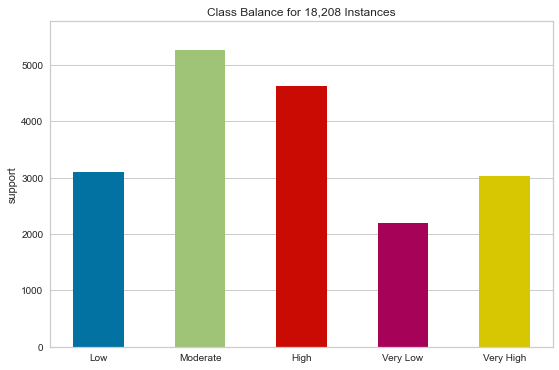

min value is Very High in values ['Low', 'Moderate', 'High', 'Very Low', 'Very High']
Resampled Value Counts: 
 Moderate     2199
Low          2199
Very High    2199
Very Low     2199
High         2199
Name: Child Opportunity Levels, education domain, nationally- normed, dtype: int64


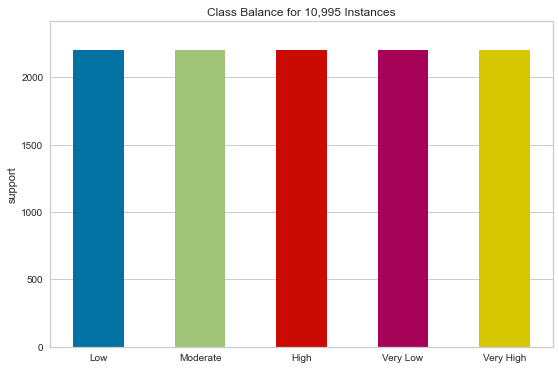

(8796, 130) (8796,)
(2199, 130) (2199,)
F1 SCORE SVC: 0.8162801273306048


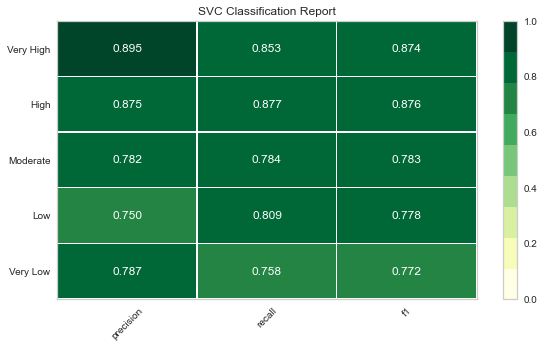

F1 SCORE NuSVC: 0.7959981809913597


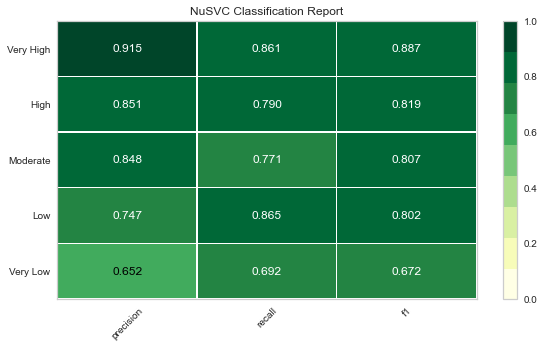

F1 SCORE LinearSVC: 0.8486584811277853


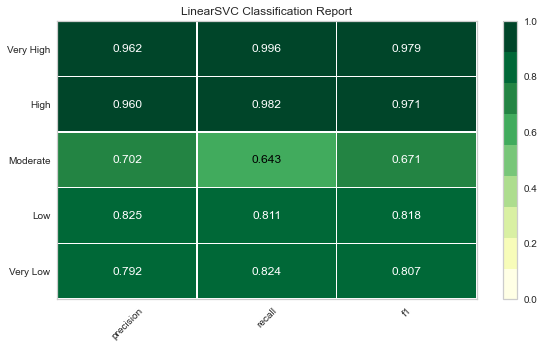

F1 SCORE SGDClassifier: 0.7498863119599818


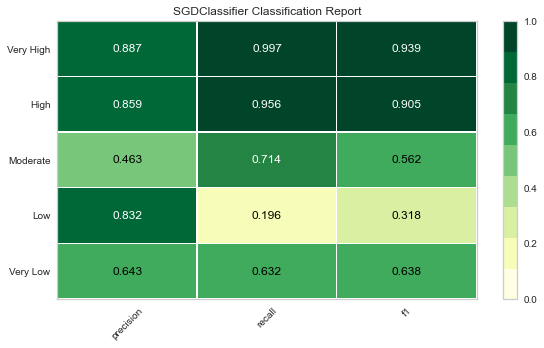

F1 SCORE KNeighborsClassifier: 0.6764893133242383


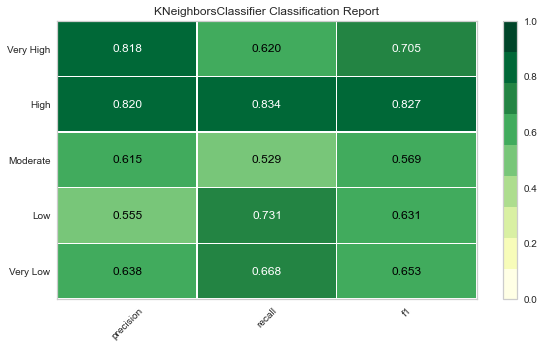

F1 SCORE LogisticRegression: 0.9461573442473852


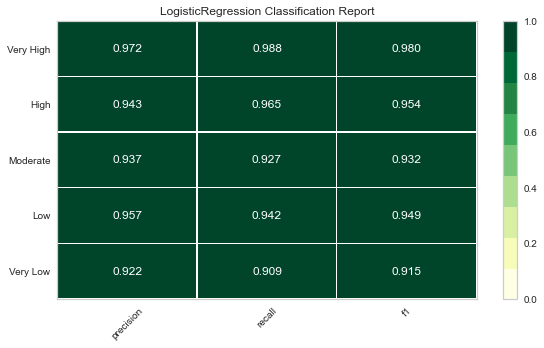

F1 SCORE LogisticRegressionCV: 0.9931787175989086


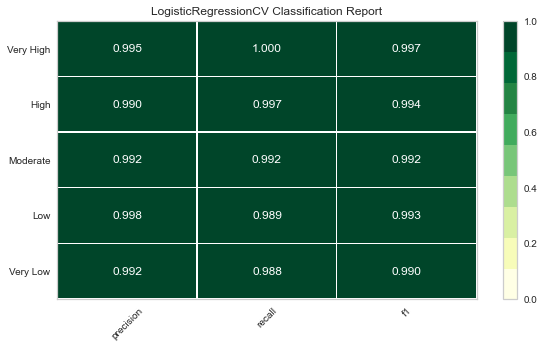

F1 SCORE BaggingClassifier: 1.0


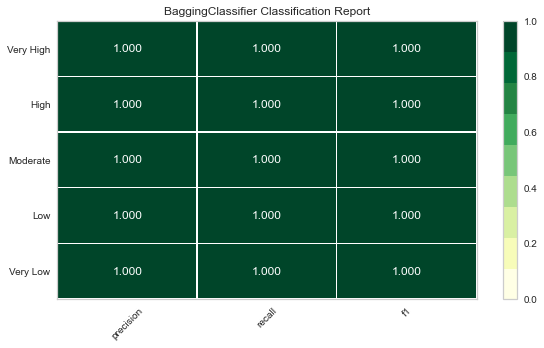

F1 SCORE ExtraTreesClassifier: 1.0


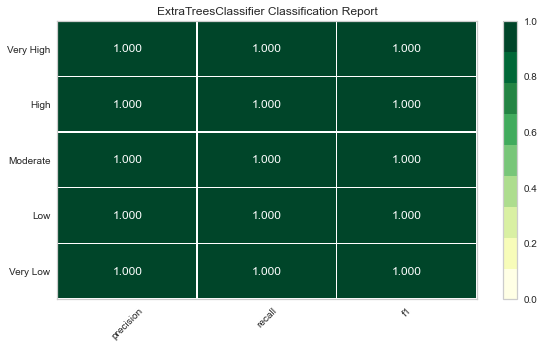

F1 SCORE RandomForestClassifier: 1.0


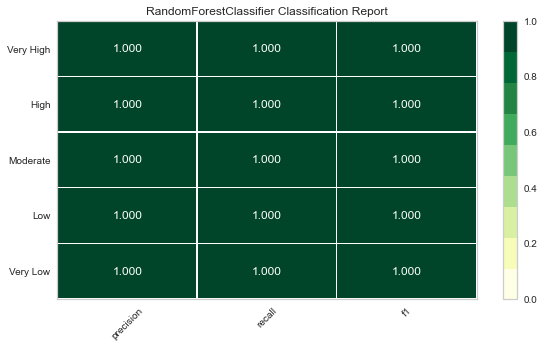

Target = Child Opportunity Levels, health and environment domain, nationally-normed
Raw Value Counts: 
 Very Low     6438
Low          4092
Moderate     3337
High         2708
Very High    1633
Name: Child Opportunity Levels, health and environment domain, nationally-normed, dtype: int64


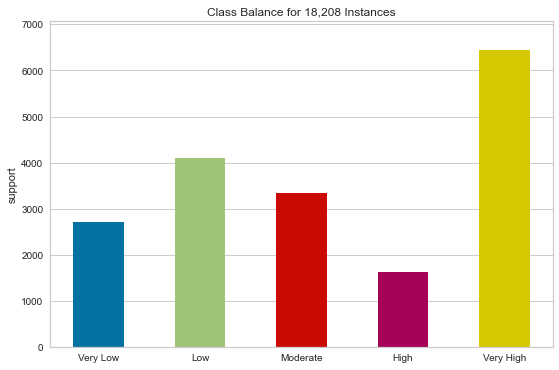

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 Moderate     1633
Low          1633
Very High    1633
Very Low     1633
High         1633
Name: Child Opportunity Levels, health and environment domain, nationally-normed, dtype: int64


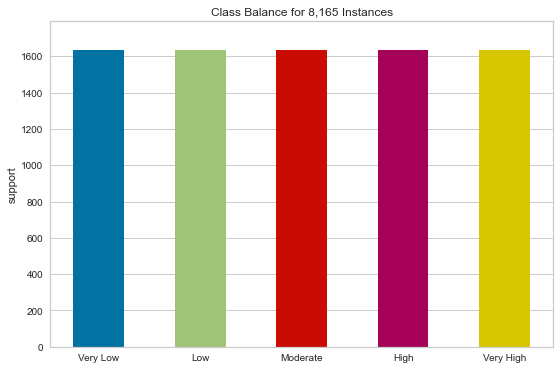

(6532, 130) (6532,)
(1633, 130) (1633,)
F1 SCORE SVC: 0.8121249234537661


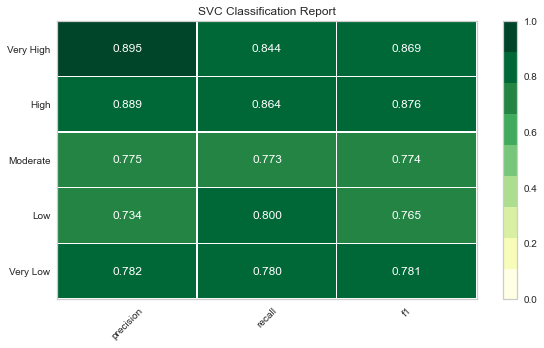

F1 SCORE NuSVC: 0.8685854255970606


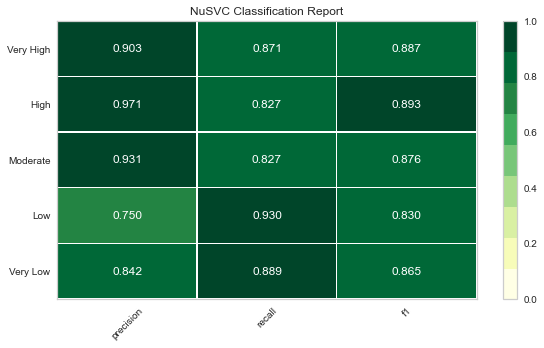

F1 SCORE LinearSVC: 0.8238824249846907


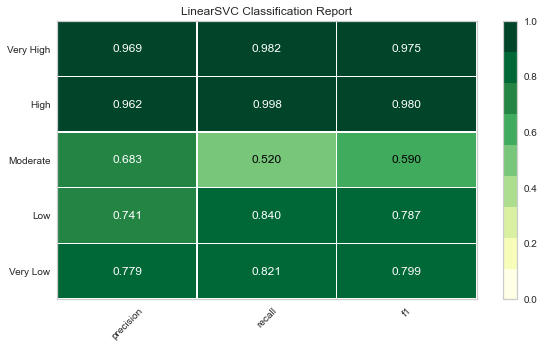

F1 SCORE SGDClassifier: 0.6739742804654011


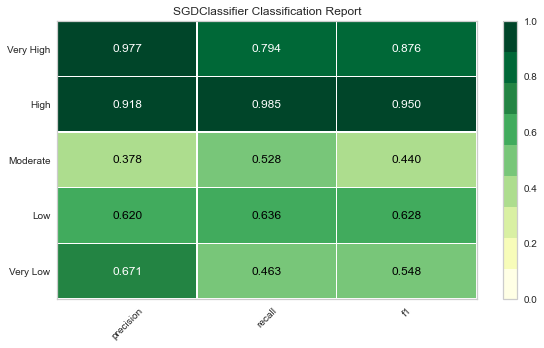

F1 SCORE KNeighborsClassifier: 0.6273116962645437


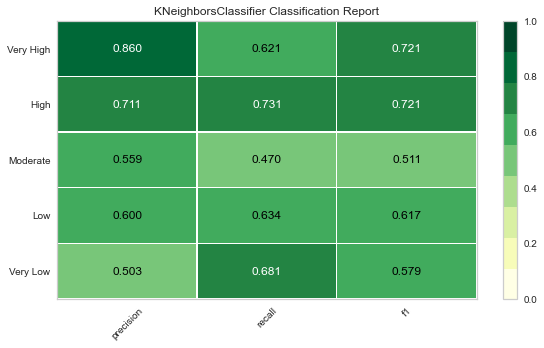

F1 SCORE LogisticRegression: 0.8777709736680954


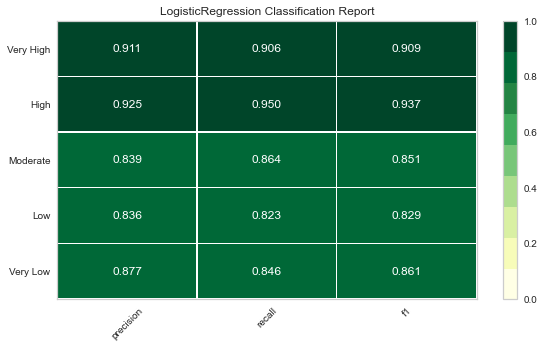

F1 SCORE LogisticRegressionCV: 0.9866503368034293


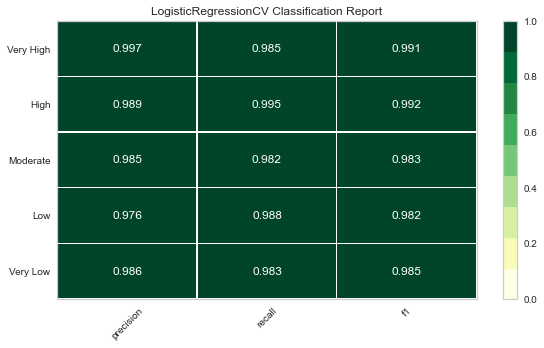

F1 SCORE BaggingClassifier: 1.0


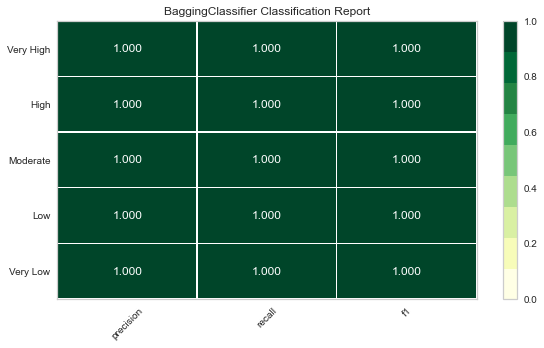

F1 SCORE ExtraTreesClassifier: 1.0


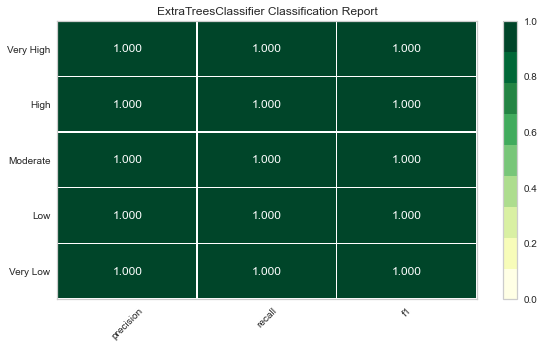

F1 SCORE RandomForestClassifier: 1.0


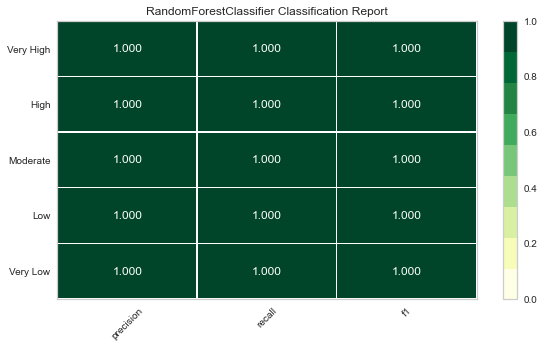

Target = Child Opportunity Levels, social and economic domain, nationally-normed
Raw Value Counts: 
 Very Low     4170
Low          3927
Moderate     3814
High         3356
Very High    2941
Name: Child Opportunity Levels, social and economic domain, nationally-normed, dtype: int64


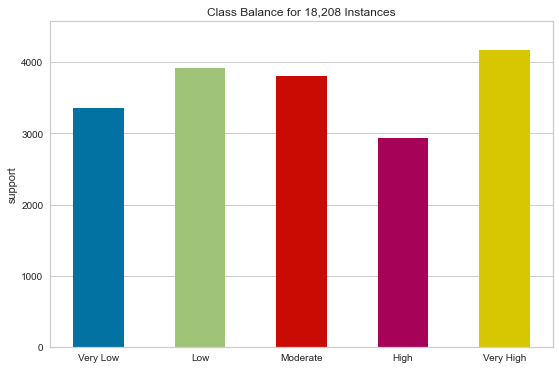

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 Moderate     2941
Low          2941
Very High    2941
Very Low     2941
High         2941
Name: Child Opportunity Levels, social and economic domain, nationally-normed, dtype: int64


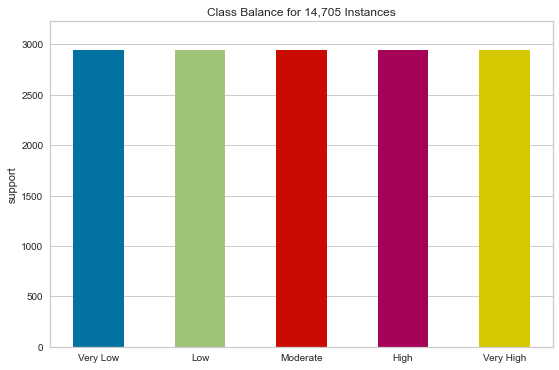

(11764, 130) (11764,)
(2941, 130) (2941,)
F1 SCORE SVC: 0.8250935056103367


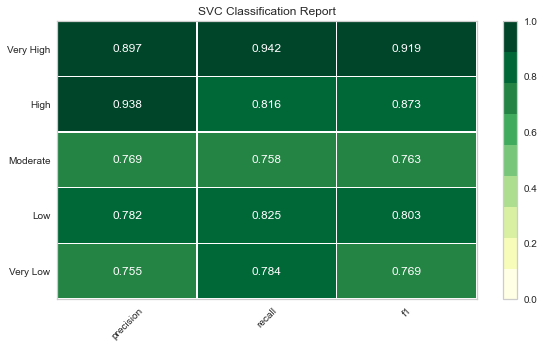

F1 SCORE NuSVC: 0.7433526011560694


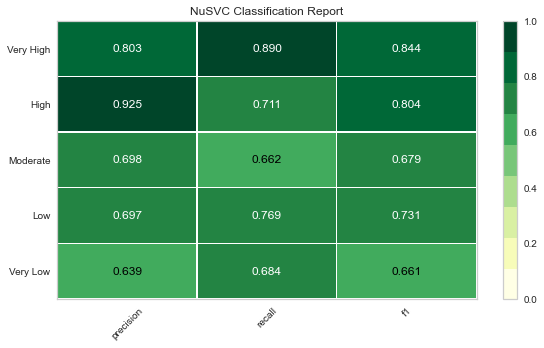

F1 SCORE LinearSVC: 0.8461747704862291


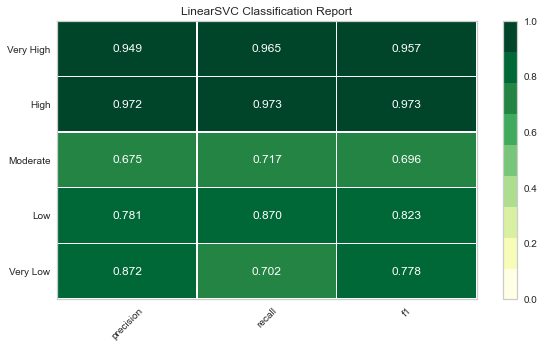

F1 SCORE SGDClassifier: 0.8325059503570215


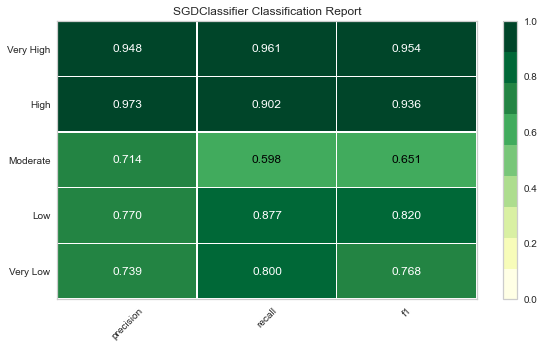

F1 SCORE KNeighborsClassifier: 0.7407684461067664


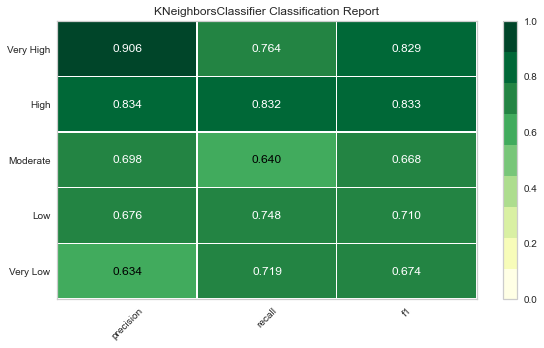

F1 SCORE LogisticRegression: 0.9323359401564094


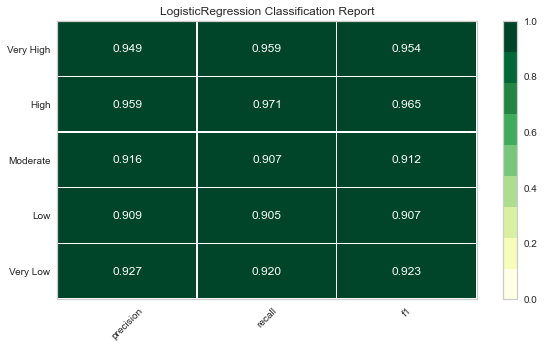

F1 SCORE LogisticRegressionCV: 0.9919755185311119


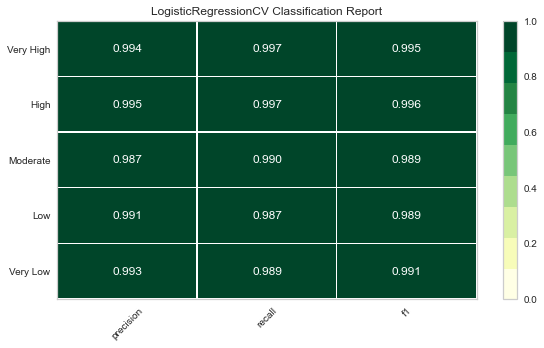

F1 SCORE BaggingClassifier: 1.0


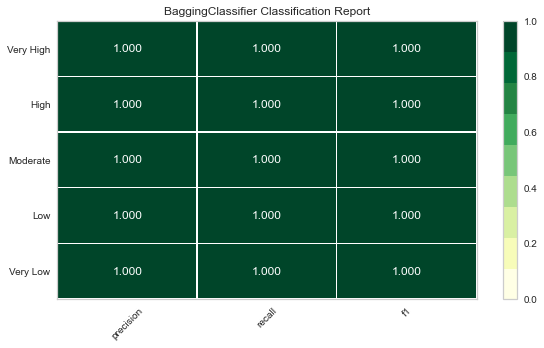

F1 SCORE ExtraTreesClassifier: 1.0


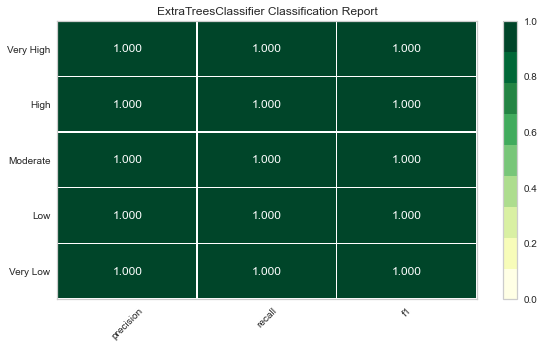

F1 SCORE RandomForestClassifier: 1.0


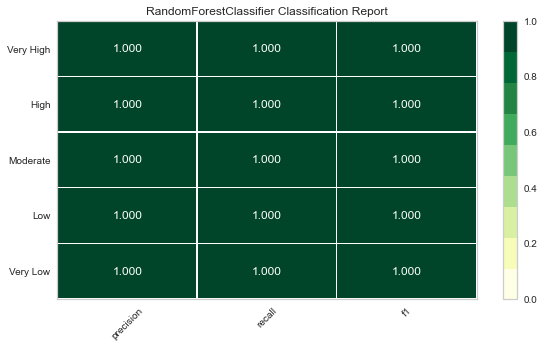

In [15]:
for i in cat_cols:
    print('Target =', i)
    data = class_balance(pct,i)
    X = data.loc[:, data.columns != i]
    y = data[i]
    train_test(X,y)
    for model in models:
        try:
            score_model(X, y, model)
            visualize_model(X, y, model)
        except:
            print("error in",model)